# `Optuna` optimization analysis - D1_20241109_114242

Nota: la prima cosa che si osserva dal post-processing è che il DRAG ha fallito, anche questo può aver influito sulla ottimizzazione con `optuna`.

Le RB per cui l'incertezza sulla fidelity è di molto superiore all'unità sono RB in cui per qualche motivo il fit non funziona (presumibilmente i parametri scelti non sono adatti.)

In [1]:
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_edf,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour
)
import matplotlib.pyplot as plt
from pathlib import Path


/home/elisa/calibration/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WIDTH  = 0.5
FONT = 24

BLUE = "#788ae3"
RED = "#d1545e"
DARKBLUE = "#075cb3"
DARKRED = "#8c1822"

### Load study from database

In [3]:
target = "D1"
study_name = "20241110_074214"
path = f"../../optuna_data/{target}_{study_name}.db"

# Construct SQLAlchemy URL
db_path = f"sqlite:///{path}"
print(db_path)

study = optuna.load_study(study_name=study_name, storage=db_path)

sqlite:///../../optuna_data/D1_20241110_074214.db


## Objeptimization analysis with optuna tools

In [4]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

In [5]:
optuna.visualization.plot_param_importances(study).show()

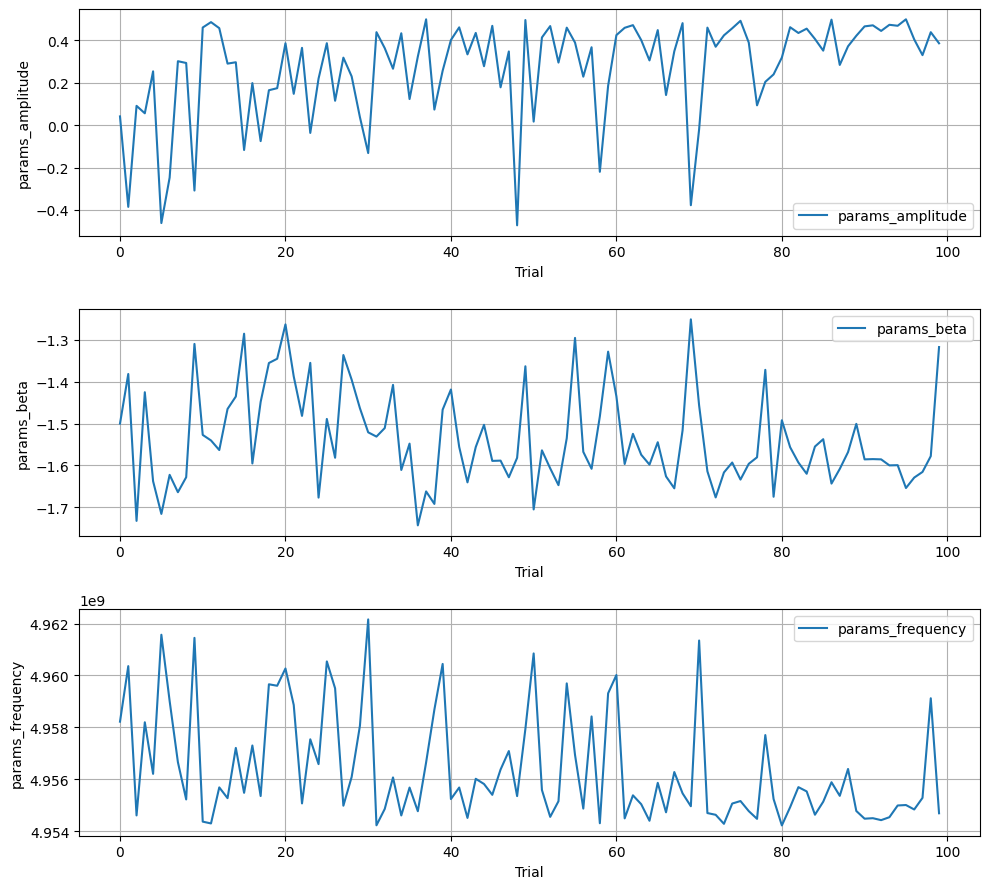

In [6]:
# Get all trials and plot parameter histories individually
trials = study.trials_dataframe()

# Separate plots for each parameter
params_columns = [col for col in trials.columns if col.startswith("params_")]

fig, axes = plt.subplots(len(params_columns), 1, figsize=(10, len(params_columns) * 3))

for i, param in enumerate(params_columns):
    ax = axes[i]
    ax.plot(trials["number"], trials[param], label=param)
    ax.set_xlabel("Trial")
    ax.set_ylabel(param)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Optimization analysis

In [7]:
df = study.trials_dataframe()

#NB: objective value is RB infidelity
objective_values = df['value'].to_numpy()
objective_error = df['user_attrs_error'].to_numpy()
iterations = df['number']

#build params dictionary
params = {par: df[par].dropna().to_numpy() for par in params_columns}
print(params)

{'params_amplitude': array([ 0.04110445, -0.38579612,  0.09096098,  0.05580593,  0.25378536,
       -0.46219564, -0.24770255,  0.30164972,  0.29327032, -0.30873531,
        0.46065553,  0.48606383,  0.45757352,  0.29026755,  0.29671208,
       -0.11739356,  0.19831612, -0.07539353,  0.16464267,  0.17432611,
        0.38643497,  0.14758724,  0.36467451, -0.03675466,  0.2194839 ,
        0.38673278,  0.11509673,  0.31842057,  0.23008085,  0.03762344,
       -0.13177384,  0.4386739 ,  0.3632593 ,  0.26615568,  0.43359495,
        0.12317627,  0.32349897,  0.49926652,  0.07343311,  0.25665713,
        0.40170184,  0.46141758,  0.33397223,  0.43511383,  0.27796697,
        0.46851527,  0.17846842,  0.34758507, -0.47283307,  0.49593725,
        0.01660185,  0.41370782,  0.46739102,  0.29516056,  0.45996006,
        0.38961005,  0.22865041,  0.36757587, -0.2203003 ,  0.1855245 ,
        0.42476163,  0.45927502,  0.47180929,  0.4013403 ,  0.30539663,
        0.44850835,  0.14213526,  0.3485867

/tmp/ipykernel_188255/806558833.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



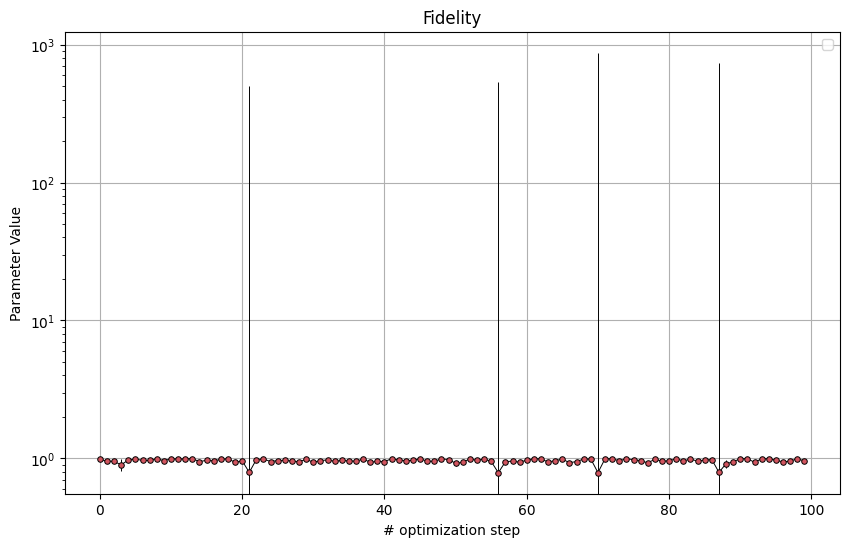

In [8]:
plt.figure(figsize=(10, 6))
plt.errorbar(iterations, 1-objective_values, yerr=objective_error, fmt = 'o', markersize=4, color='black', linestyle='-',
         markerfacecolor=RED, markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()

In [9]:
for i in range(len(objective_values)):
    if 1-objective_values[i] + objective_error[i] > 1:
        print(i)

21
56
70
87


/tmp/ipykernel_188255/3497117488.py:8: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



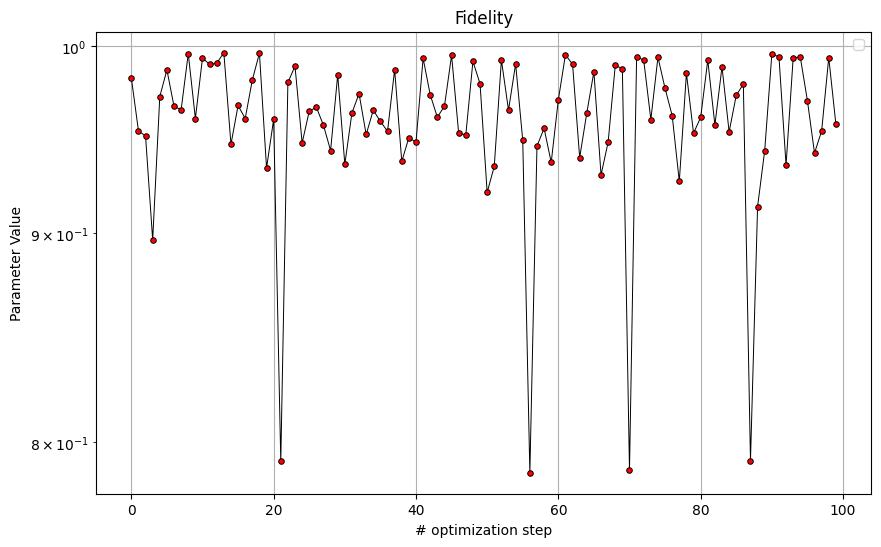

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(iterations, 1 - objective_values, 'o-', markersize=4, color='black', 
         markerfacecolor='red', markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.title(f'Fidelity')
plt.legend()
plt.grid()
plt.show()

In [11]:
best_trial = study.best_trial

print("Best trial:")
print(f"  Trial number: {best_trial.number}")
print(f"  Value (Objective): {best_trial.value}")
print("  Parameters:")

for param_name, param_value in best_trial.params.items():
    print(f"    {param_name}: {param_value}")

print(f"fidelity: {1-best_trial.value}")

Best trial:
  Trial number: 13
  Value (Objective): 0.003546476515791023
  Parameters:
    amplitude: 0.29026755023476497
    frequency: 4955279304.072351
    beta: -1.4650427984074996
fidelity: 0.996453523484209


## Inspectring database structure

In [12]:
print("Columns in Optuna study trials DataFrame")
print(df.info())
print(df.head())

Columns in Optuna study trials DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   number                     100 non-null    int64          
 1   value                      100 non-null    float64        
 2   datetime_start             100 non-null    datetime64[ns] 
 3   datetime_complete          100 non-null    datetime64[ns] 
 4   duration                   100 non-null    timedelta64[ns]
 5   params_amplitude           100 non-null    float64        
 6   params_beta                100 non-null    float64        
 7   params_frequency           100 non-null    float64        
 8   user_attrs_error           100 non-null    float64        
 9   system_attrs_fixed_params  1 non-null      object         
 10  state                      100 non-null    object         
dtypes: datetime64[ns](